In [1]:
from keras.models import Sequential
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.python.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.utils import class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# import tensorflow_addons as tfa

In [2]:
warnings.filterwarnings("ignore", category=FutureWarning)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.test.gpu_device_name())

Num GPUs Available:  1
/device:GPU:0


In [3]:
#import splitfolders
#splitfolders.ratio('F:/softcom/dataset/festivals-Splitted/train', output="F:/softcom/dataset/festivals-Splitted/output", seed=1337, ratio=(.85, 0.15)) 

In [4]:
# import pandas as pd

# train_dir = "F:/softcom/dataset/festivals-Splitted - Copy/train"
# img_height,img_width=224,224
# batch_size=100
# train_ds = tf.keras.preprocessing.image_dataset_from_directory(
#   train_dir,
#   seed=123,
#   image_size=(img_height, img_width),
#   batch_size=batch_size)

# dataset_unbatched = tuple(train_ds.unbatch())
# labels = []
# for (image,label) in dataset_unbatched:
#     labels.append(label.numpy())
# labels = pd.Series(labels)

# # adjustments
# count = labels.value_counts().sort_index()
# count.index = train_ds.class_names

# print(count)

In [5]:
train_dir = "F:/AUST/4.2/8. CSE4238 - Soft Computing Lab/Project/festivals dataset/festivals-Splitted/train"
test_dir = "F:/AUST/4.2/8. CSE4238 - Soft Computing Lab/Project/festivals dataset/festivals-Splitted/test"

# Image size and batch size
img_height,img_width = 224, 224
img_size = (img_height,img_width)
batch_size = 16

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  label_mode='categorical',
  image_size=(img_height, img_width),
  batch_size=batch_size)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  label_mode='categorical',
  image_size=(img_height, img_width),
  batch_size=batch_size)
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  test_dir,
  seed=123,
  label_mode='categorical',
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 3175 files belonging to 24 classes.
Using 2540 files for training.
Found 3175 files belonging to 24 classes.
Using 635 files for validation.
Found 804 files belonging to 24 classes.


In [6]:
class_weights_manual = {
    0: 19.3/71,
    1: 19.3/117,
    2: 19.3/90,
    3: 19.3/73,
    4: 19.3/63,
    5: 19.3/251,
    6: 19.3/272,
    7: 19.3/131,
    8: 19.3/204,
    9: 19.3/121,
    10: 19.3/193,
    11: 19.3/112,
    12: 19.3/71,
    13: 19.3/64,
    14: 19.3/98,
    15: 19.3/98,
    16: 19.3/90,
    17: 19.3/39,
    18: 19.3/50,
    19: 19.3/107,
    20: 19.3/62,
    21: 19.3/127,
    22: 19.3/64,
    23: 19.3/119
}

In [7]:
model = Sequential()
model.add(tf.keras.layers.InputLayer(input_shape=(img_height,img_width, 3), dtype=tf.uint8))
model.add(tf.keras.layers.Lambda(lambda x: tf.cast(x, tf.float32)))
model.add(tf.keras.layers.Lambda(tf.keras.applications.efficientnet.preprocess_input))

pretrained_model= tf.keras.applications.EfficientNetB7(include_top=False,
                   input_shape=(img_height,img_width,3),
                   weights='imagenet')
for layer in pretrained_model.layers[:int(len(pretrained_model.layers)*.75)]:   
       layer.trainable=False

model.add(pretrained_model)
# Add GlobalAveragePooling layer
model.add(GlobalAveragePooling2D())
# [:int(len(pretrained_model.layers)*.75)]
# Add fully connected layer with L2 regularization
model.add(Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.1)))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.1)))
model.add(Dropout(0.2))
model.add(Dense(24, activation='softmax',kernel_regularizer=tf.keras.regularizers.l2(0.1)))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 224, 224, 3)       0         
                                                                 
 lambda_1 (Lambda)           (None, 224, 224, 3)       0         
                                                                 
 efficientnetb7 (Functional)  (None, 7, 7, 2560)       64097687  
                                                                 
 module_wrapper (ModuleWrapp  (None, 2560)             0         
 er)                                                             
                                                                 
 module_wrapper_1 (ModuleWra  (None, 512)              1311232   
 pper)                                                           
                                                                 
 module_wrapper_2 (ModuleWra  (None, 512)              0

In [8]:
checkpoint_filepath = 'F:/AUST/4.2/8. CSE4238 - Soft Computing Lab/Project/Project Last Run/efficientnetckpt.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
lr_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.5,patience=5, min_lr=0.00001)

In [9]:
# optimizers = [
#     tf.keras.optimizers.Adam(learning_rate=1e-5),
#     tf.keras.optimizers.Adam(learning_rate=1e-3)
# ]
# optimizers_and_layers = [(optimizers[0:3], model.layers[0]), (optimizers[1], model.layers[3:])]
# optimizer = tfa.optimizers.MultiOptimizer(optimizers_and_layers)

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'],
              sample_weight_mode='temporal'
             )
epochs=50

In [10]:
from datetime import datetime
start = datetime.now()
history = model.fit(
  train_ds,
  validation_data=val_ds,
  verbose="auto",
  callbacks=[model_checkpoint_callback,lr_callback],
  epochs=epochs, #class_weight=class_weights_manual
)
duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/50
159/159 [==============================] - 65s 288ms/step - loss: 1.9524 - accuracy: 0.4850 - val_loss: 3.2962 - val_accuracy: 0.4598 - lr: 0.0010
Epoch 2/50
159/159 [==============================] - 42s 263ms/step - loss: 1.1002 - accuracy: 0.7098 - val_loss: 1.8956 - val_accuracy: 0.5559 - lr: 0.0010
Epoch 3/50
159/159 [==============================] - 42s 265ms/step - loss: 0.7031 - accuracy: 0.8055 - val_loss: 1.8873 - val_accuracy: 0.6110 - lr: 0.0010
Epoch 4/50
159/159 [==============================] - 41s 258ms/step - loss: 0.4672 - accuracy: 0.8701 - val_loss: 2.0856 - val_accuracy: 0.6063 - lr: 0.0010
Epoch 5/50
159/159 [==============================] - 42s 264ms/step - loss: 0.3702 - accuracy: 0.9012 - val_loss: 2.0892 - val_accuracy: 0.6724 - lr: 0.0010
Epoch 6/50
159/159 [==============================] - 43s 269ms/step - loss: 0.3233 - accuracy: 0.9122 - val_loss: 1.4269 - val_accuracy: 0.6913 - lr: 0.0010
Epoch 7/50
159/159 [==============================] 

In [11]:
import matplotlib.pyplot as plt
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["accuracy", "val accuracy"], loc="upper left")
    plt.show()

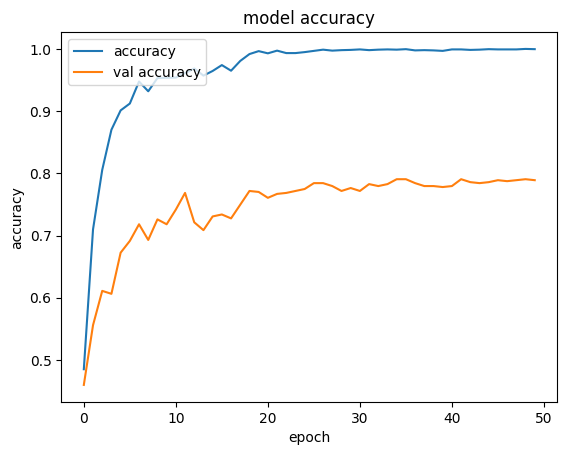

In [12]:
plot_hist(history)

In [19]:
result=model.evaluate(
    test_ds,
    batch_size=batch_size,
    verbose="auto"
)
#8346

51/51 [==============================] - 8s 143ms/step - loss: 1.1341 - accuracy: 0.8346


In [18]:
#save

# model.save_weights('F:/AUST/4.2/8. CSE4238 - Soft Computing Lab/Project/Project Last Run/efficientnet.h5', overwrite=True, save_format=None, options=None)

#load

# model.load_weights('F:/AUST/4.2/8. CSE4238 - Soft Computing Lab/Project/Project Last Run/efficientnetckpt.h5', skip_mismatch=False, by_name=False, options=None)

# model.load_weights('F:/AUST/4.2/8. CSE4238 - Soft Computing Lab/Project/Project Last Run/efficientnet.h5', skip_mismatch=False, by_name=False, options=None)


1/1 [==============================] - 0s 36ms/step


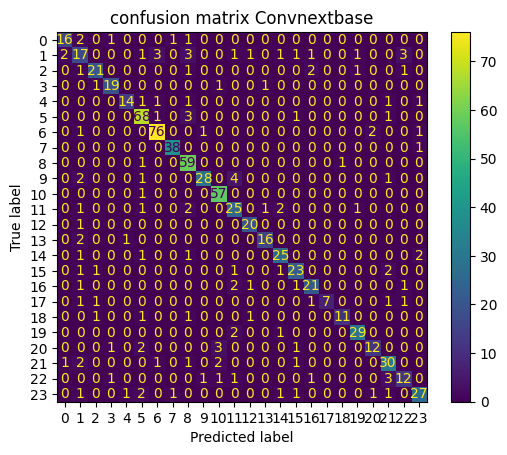

accuracy:  83.45771144278606
precision: [0.84210526 0.5        0.84       0.86363636 0.875      0.85
 0.92682927 0.95       0.80821918 0.93333333 0.890625   0.69444444
 0.86956522 0.88888889 0.80645161 0.79310345 0.80769231 1.
 0.91666667 0.90625    0.8        0.75       0.66666667 0.84375   ]
recall: [0.76190476 0.48571429 0.77777778 0.86363636 0.73684211 0.91891892
 0.9382716  0.97435897 0.96721311 0.77777778 0.98275862 0.75757576
 0.95238095 0.84210526 0.83333333 0.79310345 0.77777778 0.58333333
 0.73333333 0.90625    0.63157895 0.78947368 0.6        0.75      ]
fscore: [0.8        0.49275362 0.80769231 0.86363636 0.8        0.88311688
 0.93251534 0.96202532 0.88059701 0.84848485 0.93442623 0.72463768
 0.90909091 0.86486486 0.81967213 0.79310345 0.79245283 0.73684211
 0.81481481 0.90625    0.70588235 0.76923077 0.63157895 0.79411765]
support: [21 35 27 22 19 74 81 39 61 36 58 33 21 19 30 29 27 12 15 32 19 38 20 36]


In [15]:
y_true = []
y_pred = []
for x,y in test_ds:
  y= tf.argmax(y,axis=1)
  y_true.append(y)
  y_pred.append(tf.argmax(model.predict(x),axis = 1))
  
y_pred = tf.concat(y_pred, axis=0)
y_true = tf.concat(y_true, axis=0)
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("confusion matrix Convnextbase")
plt.show()
precision, recall, fscore, support = score(y_true, y_pred)

print("accuracy: ",100*accuracy_score(y_true, y_pred))
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))